In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
from dl import authClient as ac, queryClient as qc
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from stringUtils import EventCalculator, ExperimentExpectationsCalculator
from scipy.stats import binned_statistic_2d
from scipy import integrate
from itertools import product

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

bin_size = 7 * u.arcmin 
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")

In [2]:
def make_time_intervals(observation_times, exposure_time, lensing_times, detection_threshold=0.9):
    t_obs = Time(np.tile(observation_times.values, (len(lensing_times), 1)), format="mjd")
    t_lens = lensing_times.reshape(len(lensing_times), 1)
    t_start = (t_obs - t_lens + exposure_time * detection_threshold).value
    t_end = (t_obs + (1 - detection_threshold) * exposure_time).value
    intervals = Time([[ts, te] for ts, te in zip(t_start, t_end)], format="mjd")
    intervals = intervals.transpose((0, 2, 1))
    return intervals

def calculate_time_observed(time_intervals):
    temp = intervals.copy().value
    temp[:, :-1, 1] = temp[:, 1:, 0] - temp[:, :-1, 1]
    temp[:, 1:, 0] = temp[:, 1:, 0] - temp[:, :-1, 1]
    mask = temp > 0
    time_deltas = [compute_time_deltas(intervals_slice, mask_slice)
                   for intervals_slice, mask_slice in zip(intervals, mask)]
    time_observed = np.sum(time_deltas, axis=1) * u.s
    return time_observed

def estimate_time_observed(n_detections, exposure_time, lensing_times, detection_threshold):
    temp = lensing_times + (1 - 2 * detection_threshold) * exposure_time
    time_window = np.where(lensing_times > detection_threshold * exposure_time, 
                           temp, 0 * u.s)
    time_observed = time_window * n_detections
    return time_observed

def compute_time_deltas(intervals_slice, mask_slice):
    new_intervals = intervals_slice[mask_slice]
    n_true = np.count_nonzero(~mask_slice[:, 0])
    new_intervals = new_intervals.reshape((len(intervals_slice) - n_true, 2))
    time_deltas = (new_intervals[:, 1] - new_intervals[:, 0]).to(u.s)
    return time_deltas

def set_n_events(df, 
                 eventCalculator, 
                 exposure_time=60*u.s, 
                 detection_threshold=0.9, 
                 n_steps=10000):
    detection_time = detection_threshold * exposure_time
    n_tensions = len(eventCalculator.tensions)
    source_distance = eventCalculator.hostGalaxySkyCoordinates[0]
    df_array = df[["n_detections", "ra", "dec"]].values
    n_events_array = np.zeros((df_array.shape[0], n_tensions))
    
    for idx, (n_detections, ra, dec) in enumerate(df_array):
        source_coordinates = [source_distance, SkyCoord(ra, dec, unit="deg")]
        eventCalculator.sourceSkyCoordinates = source_coordinates
        eventCalculator.calculate(nSteps=n_steps)
        event_rates = eventCalculator.results["eventRates"].decompose()
        event_rates = event_rates.reshape((len(event_rates), 1))
        x = np.linalg.norm(eventCalculator.results["lineOfSight"], axis=0)
        lensing_times = eventCalculator.computeLensingTimeSamples(x)
        distance_pdf = eventCalculator.computeDistancePDF()
        lensing_window = np.where(lensing_times > detection_time, 
                                  lensing_times + (1 - 2 * detection_threshold) * exposure_time, 0)
        temp =  lensing_window * event_rates * distance_pdf * n_detections
        n_events = temp.sum(axis=1).decompose()

        n_events_array[idx] = n_events

    df.loc[:, df.columns[-n_tensions:]] = n_events_array

def reduce_dataframe(object_df, bin_size):
    bin_step = bin_size.to(u.deg)
    bin_step = bin_step.value
    ra_bounds = np.array([object_df["ra"].min(), object_df["ra"].max() + bin_step])
    dec_bounds = np.array([object_df["dec"].min(), object_df["dec"].max() + bin_step])
    ra_bins = np.arange(ra_bounds[0], ra_bounds[1], bin_step)
    dec_bins = np.arange(dec_bounds[0], dec_bounds[1], bin_step)
    s, r, d, n = binned_statistic_2d(object_df["ra"], object_df["dec"], object_df["ndet"],
                                     bins=[ra_bins, dec_bins], statistic="sum")
    c, r, d, n = binned_statistic_2d(object_df["ra"], object_df["dec"], object_df["ndet"],
                                     bins=[ra_bins, dec_bins], statistic="count")
    ra = (ra_bins[1:] + ra_bins[:-1]) / 2
    dec = (dec_bins[1:] + dec_bins[:-1]) / 2
    s_coords = cartesian_product(ra, dec)
    ij_coords = cartesian_product(range(len(ra)), range(len(dec)))
    reduced_df = np.stack((s.ravel(), c.ravel(), s_coords[:, 0], s_coords[:, 1], ij_coords[:, 0], ij_coords[:, 1]))
    reduced_df = pd.DataFrame(data=reduced_df.transpose(), 
                              columns=["n_detections", "n_objects", "ra", "dec", "ra_idx", "dec_idx"])
    reduced_df = reduced_df.loc[reduced_df["n_detections"] != 0]
    reduced_df.reset_index(inplace=True, drop=True)

    return reduced_df

def cartesian_product(x, y):
    return np.array(list(product(x, y)))

In [3]:
# ra_query_bounds = (lmc_center.ra.deg - 10, lmc_center.ra.deg + 10)
# dec_query_bounds = (lmc_center.dec.deg - 10, lmc_center.dec.deg + 10)

# query = f"""
# SELECT ndet,ra,dec FROM smash_dr2.object
# WHERE ndet>5
# AND ra>{ra_query_bounds[0]} AND ra<{ra_query_bounds[1]}
# AND dec>{dec_query_bounds[0]} AND dec<{dec_query_bounds[1]}
# """
# object_df = qc.query(sql=query, fmt="pandas")
# reduced_df = reduce_dataframe(object_df, bin_size)

The query takes 1s CPU time and ~10s for 1e6 objects so ~100s, 1000s for 1e8? 

In [6]:
lowest_tension = -11
highest_tension = -8
lmc_distance = 50 * u.kpc
lmc_mass = 1.38e11 * u.solMass

ec_config = dict(tensions = np.logspace(lowest_tension, highest_tension, num=4),
                 curlyG = 1e4,
                 hostGalaxySkyCoordinates = [lmc_distance, lmc_center],
                 hostGalaxyMass = lmc_mass,
                 )

eventCalculator = EventCalculator(ec_config)
labels = [f"{i}_events" for i in range(lowest_tension, highest_tension + 1)]

# n_rows = len(reduced_df)
# for label in labels:
#     reduced_df[label] = np.zeros(n_rows)

# set_n_events(reduced_df, eventCalculator, exposure_time=30*u.s, detection_threshold=0.9)
# reduced_df.to_feather("/dlusers/adriansh/work/analyses/results/strings/smash_main_body_lsst.feather")
# reduced_df.to_feather("/dlusers/adriansh/work/analyses/results/strings/smash_limit_1000000.feather")
# reduced_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/smash_limit_1000000.feather")

In [7]:
reduced_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/smash_main_body_lsst.feather")
reduced_df.loc[:, "n_detections"] = reduced_df.loc[:, "n_objects"] * 848
set_n_events(reduced_df, eventCalculator, exposure_time=30*u.s, detection_threshold=0.9)
reduced_df.to_feather("/dlusers/adriansh/work/analyses/results/strings/smash_main_body_lsst.feather")

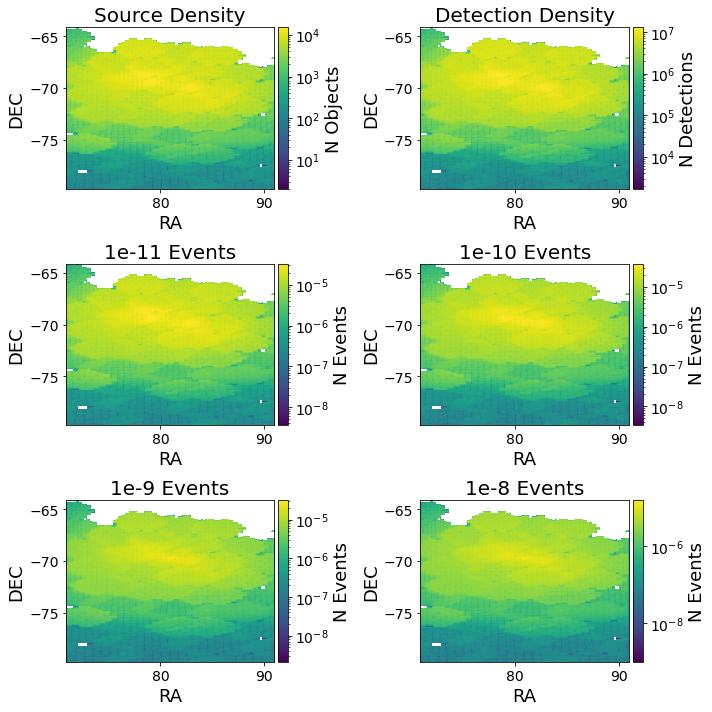

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
columns = ["n_objects", "n_detections"] + labels
cbar_labels = ["N Objects", "N Detections"] + 4 * ["N Events"]
titles = ["Source Density", "Detection Density"] + [f"1e{i} Events" for i in range(lowest_tension, highest_tension+1)]
half_bin = bin_size.to(u.deg) / 2
half_bin = half_bin.value
extent = (reduced_df["ra"].min() - half_bin, reduced_df["ra"].max() + half_bin,
          reduced_df["dec"].min() - half_bin, reduced_df["dec"].max() + half_bin)
idx_pairs = reduced_df[["ra_idx", "dec_idx"]].values.astype(int)

for iax, ax in enumerate(axs.ravel()):
    z = np.zeros((int(reduced_df["ra_idx"].max()+1), int(reduced_df["dec_idx"].max()+1))) * np.nan
    z[idx_pairs[:, 0], idx_pairs[:, 1]] = reduced_df[columns[iax]].values
    im = ax.imshow(np.rot90(z), extent=extent, aspect="auto", norm="log")
    ax.tick_params(labelsize=14)
    ax.set_xlabel("RA", fontsize=18)
    ax.set_ylabel("DEC", fontsize=18)
    ax.set_title(titles[iax], fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(cbar_labels[iax], fontsize=18)
    cb.ax.tick_params(labelsize=14)
fig.tight_layout()
# fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/smash_main_body.png")
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/smash_main_body_lsst.png")
# fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/smash_limit_1000000.png")
plt.show(fig)

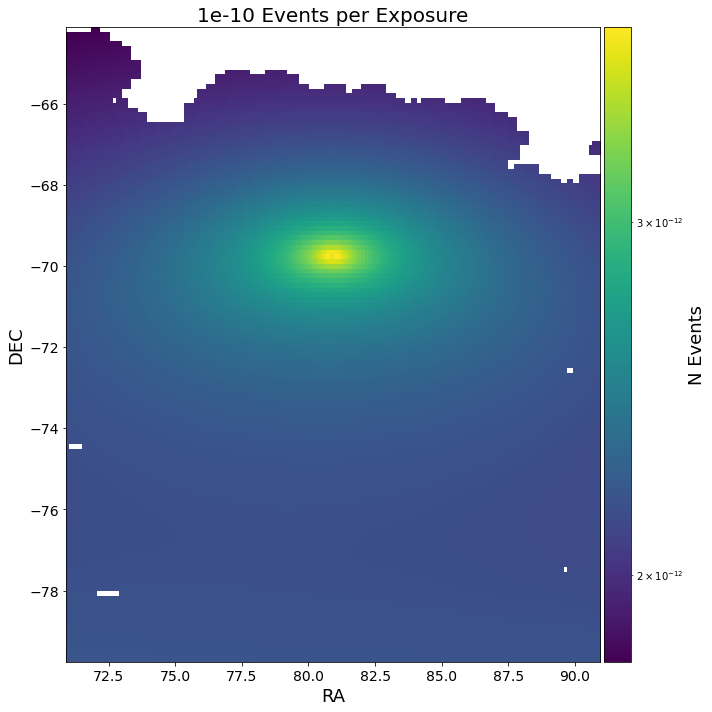

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
half_bin = 7 / 2 * u.arcmin
half_bin = half_bin.to(u.deg)
half_bin = half_bin.value
extent = (reduced_df["ra"].min() - half_bin, reduced_df["ra"].max() + half_bin,
          reduced_df["dec"].min() - half_bin, reduced_df["dec"].max() + half_bin)
idx_pairs = reduced_df[["ra_idx", "dec_idx"]].values.astype(int)

z = np.zeros((int(reduced_df["ra_idx"].max()+1), int(reduced_df["dec_idx"].max()+1))) * np.nan
eventrate_10 = reduced_df["-10_events"] / reduced_df["n_detections"]
z[idx_pairs[:, 0], idx_pairs[:, 1]] = eventrate_10.values
im = ax.imshow(np.rot90(z), extent=extent, aspect="auto", norm="log", 
               vmin=np.nanmin(z), vmax=np.nanmax(z))
ax.tick_params(labelsize=14)
ax.set_xlabel("RA", fontsize=18)
ax.set_ylabel("DEC", fontsize=18)
ax.set_title("1e-10 Events per Exposure", fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)
cb.set_label("N Events", fontsize=18)
cb.ax.tick_params(labelsize=14)
fig.tight_layout()
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/smash_main_body_1e-10events_per_exposure_lsst.png")
plt.show(fig)

In [13]:
reduced_df.loc[:, reduced_df.columns[-4:]].sum(axis=0) * 1.8e9 / 8.5e7

-11_events    3.605681
-10_events    3.555910
-9_events     2.263399
-8_events     1.055762
dtype: float64

In [21]:
reduced_df.loc[:, "n_objects"].sum(axis=0)

84955332.0

In [57]:
idx_min = (reduced_df["-10_events"] / reduced_df["n_detections"]).idxmin()
idx_max = (reduced_df["-10_events"] / reduced_df["n_detections"]).idxmax()
ra_dec_min = reduced_df[["ra", "dec"]].iloc[idx_min]
ra_dec_max = reduced_df[["ra", "dec"]].iloc[idx_max]
skycoord_min = [lmc_distance, SkyCoord(ra_dec_min["ra"], ra_dec_min["dec"], unit="deg")]
skycoord_max = [lmc_distance, SkyCoord(ra_dec_max["ra"], ra_dec_max["dec"], unit="deg")]

ec_config_min = ec_config.copy()
ec_config_max = ec_config.copy()

ec_config_min["sourceSkyCoordinates"] = skycoord_min
ec_config_max["sourceSkyCoordinates"] = skycoord_max

ec_min = EventCalculator(ec_config_min)
ec_max = EventCalculator(ec_config_max)

ec_min.calculate(nSteps=1000000)
ec_max.calculate(nSteps=1000000)

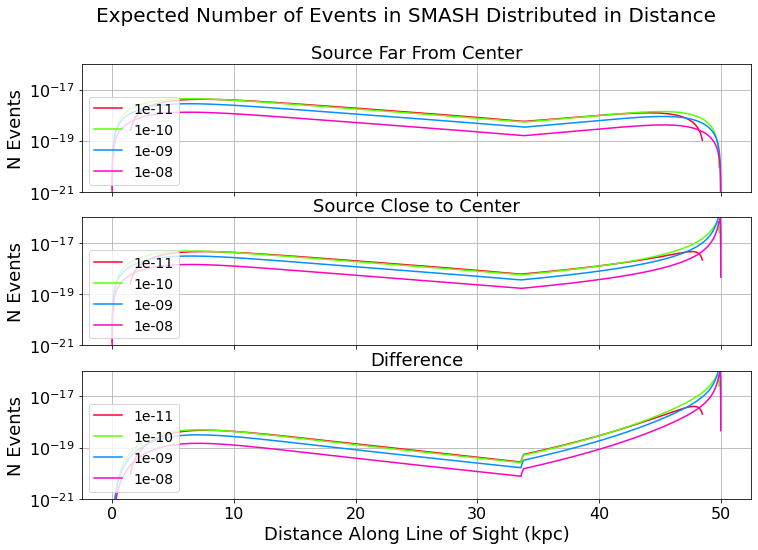

In [58]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
fig.suptitle("Expected Number of Events in SMASH Distributed in Distance", 
             fontsize=20)
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ec_min.tensions)))
titles = ["Source Far From Center", "Source Close to Center", "Difference"]

enhancement_min = ec_min.results["enhancementFactor"]
enhancement_max = ec_max.results["enhancementFactor"]

x = np.linalg.norm(ec_min.results["lineOfSight"], axis=0)
lensing_times = ec_min.computeLensingTimeSamples(x)
distance_pdf_min = ec_min.computeDistancePDF()
distance_pdf_max = ec_max.computeDistancePDF()

delta = 0.9
t_exposure = 60 * u.s
detection_time = delta * t_exposure
lensing_window = np.where(lensing_times > detection_time, 
                          lensing_times + (1 - 2 * delta) * t_exposure, np.nan)

n_events_min =  lensing_window * ec_min.results["eventRates"].reshape((lensing_window.shape[0], 1)) * distance_pdf_min
n_events_max =  lensing_window * ec_max.results["eventRates"].reshape((lensing_window.shape[0], 1)) * distance_pdf_max
n_events_min = n_events_min.decompose()
n_events_max = n_events_max.decompose()

ys = [n_events_min, n_events_max, n_events_max - n_events_min]
ylims = (1e-21, 1e-16)

for ax, t, yy in zip(axs.ravel(), titles, ys):
    ax.set_title(t, fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(visible=True)

    for y, ten, c in zip(yy, ec_min.tensions, colors):
        ax.semilogy(x, y, label=f"{ten}", color=c)
        ax.set_ylabel("N Events", fontsize=18)

    ax.legend(fontsize=14, loc="lower left")
    ax.set_ylim(ylims)

axs[2].set_xlabel(f"Distance Along Line of Sight ({x.unit})", fontsize=18)
plt.show(fig)
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/n_events_expected_LOS.png")

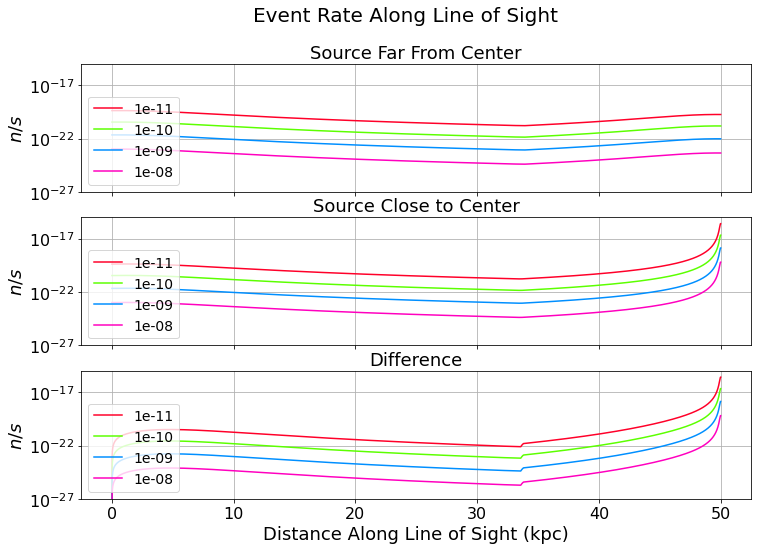

In [59]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
fig.suptitle("Event Rate Along Line of Sight", fontsize=20)
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ec_min.tensions)))
titles = ["Source Far From Center", "Source Close to Center", "Difference"]

event_rates_min = ec_min.results["eventRates"].decompose().reshape((len(distance_pdf_min), 1))
event_rates_max = ec_max.results["eventRates"].decompose().reshape((len(distance_pdf_max), 1))

x = np.linalg.norm(ec_min.results["lineOfSight"], axis=0)
distance_pdf_min = ec_min.computeDistancePDF()
distance_pdf_max = ec_max.computeDistancePDF()

y0 = distance_pdf_min * event_rates_min
y1 = distance_pdf_max * event_rates_max
ys = [y0, y1, y1-y0]
ylims = (1e-27, 1e-15)

for ax, t, yy in zip(axs.ravel(), titles, ys):
    ax.set_title(t, fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(visible=True)

    for y, ten, c in zip(yy, ec_min.tensions, colors):
        ax.semilogy(x, y, label=f"{ten}", color=c)
        ax.set_ylabel("$n/s$", fontsize=18)

    ax.legend(fontsize=14, loc="lower left")
    ax.set_ylim(ylims)

axs[2].set_xlabel(f"Distance Along Line of Sight ({x.unit})", fontsize=18)
plt.show(fig)
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/event_rate_LOS.png")

In [60]:
integrals_min = np.nansum(n_events_min, axis=1).decompose()
integrals_max = np.nansum(n_events_max, axis=1).decompose()
integrals_min, integrals_max, (integrals_max - integrals_min) / integrals_min

(<Quantity [1.68795476e-12, 1.78792121e-12, 1.14270930e-12, 5.33199218e-13]>,
 <Quantity [2.12368033e-12, 3.33601193e-12, 2.77258432e-12, 1.34841266e-12]>,
 <Quantity [0.25813818, 0.8658607 , 1.42632516, 1.52890967]>)

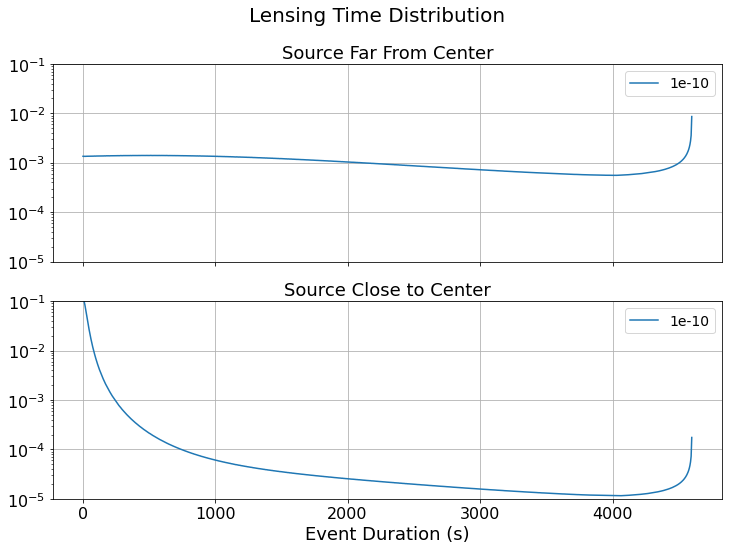

In [61]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
fig.suptitle("Lensing Time Distribution", fontsize=20)
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ec_min.tensions)))
titles = ["Source Far From Center", "Source Close to Center"]

lensing_time_pdf_min, lensing_time_bins_min = ec_min.computeLensingTimePDF()
lensing_time_pdf_max, lensing_time_bins_max = ec_max.computeLensingTimePDF()
times = (lensing_time_bins_min[:, 1:] + lensing_time_bins_min[:, :-1]) / 2
ys = [lensing_time_pdf_min, lensing_time_pdf_max]
ylims = (1e-5, 1e-1)

for ax, tt, yy in zip(axs.ravel(), titles, ys):
    ax.set_title(tt, fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(visible=True)

    for t, y, ten, c in zip(times[1:2], yy[1:2], ec_min.tensions[1:2], colors[1:2]):
        ax.semilogy(t, y, label=f"{ten}")

    ax.legend(fontsize=14, loc="upper right")
    ax.set_ylim(ylims)

axs[1].set_xlabel(f"Event Duration ({t.unit})", fontsize=18)
plt.show(fig)
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/t_lens_pdf.png")

In [62]:
ec_min.results["eventRates"].decompose(), ec_max.results["eventRates"].decompose()

(<Quantity [1.10893892e-14, 9.30909849e-16, 5.81979417e-17, 2.70961523e-18] 1 / s>,
 <Quantity [5.82068063e-13, 4.88622849e-14, 3.05473662e-15, 1.42224289e-16] 1 / s>)

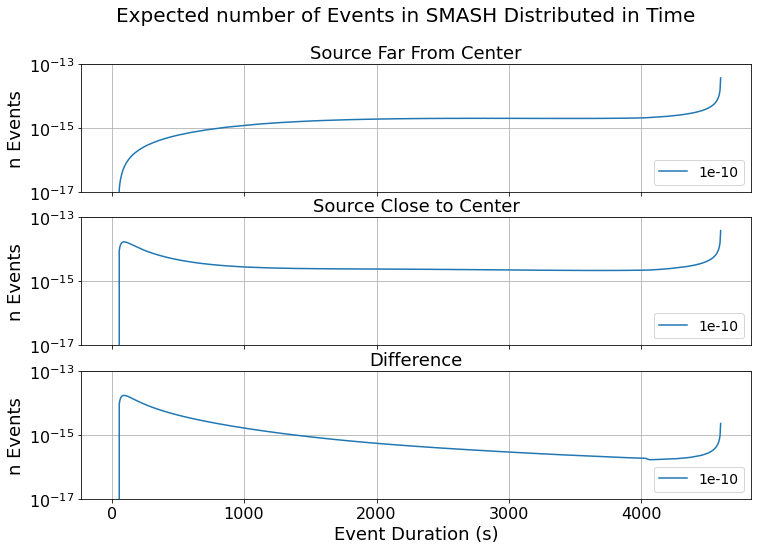

In [63]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ec_min.tensions)))
fig.suptitle("Expected number of Events in SMASH Distributed in Time", fontsize=20)
titles = ["Source Far From Center", "Source Close to Center", "Difference"]

lensing_time_pdf_min, lensing_time_bins_min = ec_min.computeLensingTimePDF()
lensing_time_pdf_max, lensing_time_bins_max = ec_max.computeLensingTimePDF()
times = (lensing_time_bins_min[:, 1:] + lensing_time_bins_min[:, :-1]) / 2
d = 0.9
tx = 60 * u.s
window_duration = np.where(times > d * tx, times + (1 - 2 * d) * tx, 0)

n_events_min = (window_duration * 
                ec_min.results["eventRates"].reshape((window_duration.shape[0], 1))
                * lensing_time_pdf_min).decompose()
n_events_max = (window_duration * 
                ec_max.results["eventRates"].reshape((window_duration.shape[0], 1))
                * lensing_time_pdf_max).decompose()
ys = [n_events_min, n_events_max, n_events_max - n_events_min]
ylims = (1e-17, 1e-13)

for ax, tt, yy in zip(axs.ravel(), titles, ys):
    ax.set_title(tt, fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(visible=True)

    for t, y, ten, c in zip(times[1:2], yy[1:2], ec_min.tensions[1:2], colors[1:2]):
        ax.semilogy(t, y, label=f"{ten}")
        ax.set_ylabel("n Events", fontsize=18)

    ax.legend(fontsize=14, loc="lower right")
    ax.set_ylim(ylims)

axs[2].set_xlabel(f"Event Duration ({t.unit})", fontsize=18)
plt.show(fig)
fig.savefig("/dlusers/adriansh/work/analyses/plots/strings/n_events_expected_time.png")

In [64]:
np.nansum(n_events_min[1]), np.nansum(n_events_max[1])

(<Quantity 1.78791194e-12>, <Quantity 3.33455971e-12>)

In [ ]:
n_observations = np.zeros(len(object_ids_df))

for i, object_id in enumerate(object_ids_df["id"]):
    query = f"""
    SELECT mjd,cmag,cerr,filter
    FROM smash_dr2.source
    WHERE id='{object_id}' AND cmag<99
    ORDER BY mjd ASC
    """
    lightcurve_df = qc.query(sql=query, fmt="pandas")
    
    n_observations[i] = len(lightcurve_df)

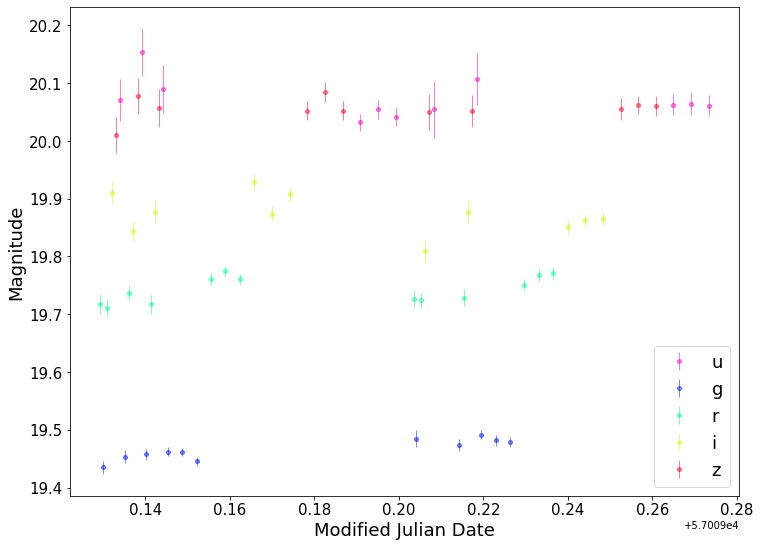

In [32]:
filters = ['u', 'g', 'r', 'i', 'z']
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(filters))[::-1])

fig, ax = plt.subplots(figsize=(12, 9))

for f, c in zip(filters, colors):
    condition = lightcurve_df["filter"] == f
    ax.errorbar(lightcurve_df['mjd'][condition], lightcurve_df['cmag'][condition], 
                yerr=lightcurve_df['cerr'][condition],
                marker='.', ms=8, ls='none', color=c, lw=1, alpha=0.5, label=f)
ax.set_xlabel('Modified Julian Date', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.legend(fontsize=18)
ax.tick_params(labelsize=15)

In [45]:
len(reduced_df)

20456